# Regularization for Deep Learning

If you are familier with following concepts you can move to next notebook:
> Reference http://www.deeplearningbook.org/contents/regularization.html

    1. Parameter Norm Penalties
    2. Norm Penalties as Constrained Optimization
    3. Regularization and Under-Constrained Problems
    4. Dataset Augmentation
    5. Noise Robustness
    6. Semi-Supervised Learning
    7. Multitask Learning
    8. Early Stopping
    9. Parameter Tying and Parameter Sharing
    10. Sparse Representations
    11. Bagging and Other Ensemble Methods
    12. Dropout
    13. Adversarial Training
    14. Tangent Distance, Tangent Prop and ManifoldTangent Classiﬁer

In [1]:
# imports
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, './reg')
import numpy as np
import matplotlib.pyplot as plt
import oneoutnn as nn # the nueral network model we created in previous lecture

A central problem in machine learning is how to make an algorithm that will perform well not just on the training data, but also on new inputs. Many strategies used in machine learning are explicitly designed to reduce the test error, possibly at the expense of increased training error. These strategies are known collectively as regularization.

> Read page 224 - 225 : http://www.deeplearningbook.org/contents/regularization.html

### 1. Parameter Norm Penalties

> Read page 226 - 233: L2, L1 regularizations and there effects and usefull ness....

to get a better understanding of implementation of L1 regularization read here : http://ufldl.stanford.edu/wiki/index.php/Sparse_Coding:_Autoencoder_Interpretation

also for applications of these methods like lasso and ridge using l2 and l1 respectively read here :<br>
https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/

Let's apply L2 regularization to our model....
we only need to change cost function and update rules....

We will try to fit a quadratic data


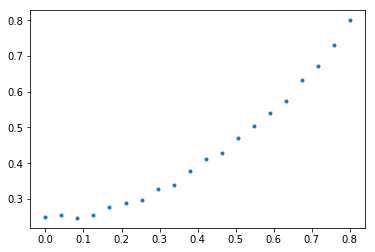

the training data...


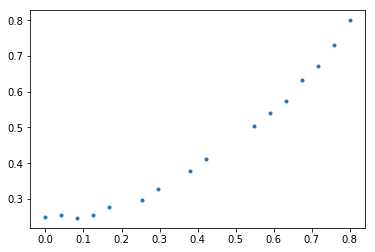

In [2]:
# defining the data to fit.......
np.random.seed(1)
n_points = 20
# we are limiting the output to 0 to one since the output node gives probability between 0 to 1
X = np.linspace(0,0.8,n_points).reshape(n_points,1)
np.random.shuffle(X)
X = X.T
Y = abs(X**2)+np.random.randn(1,n_points)*0.01  + 0.3
Y = 0.8*Y/np.max(Y)
print("We will try to fit a quadratic data")
plt.plot(X.T,Y.T,'.')
plt.show()

tr_size = 16
x_tr = X[0,:tr_size].reshape(1,tr_size)
y_tr = Y[0,:tr_size].reshape(1,tr_size)
x_te = X[0,tr_size:].reshape(1,n_points-tr_size)
y_te = Y[0,tr_size:].reshape(1,n_points-tr_size)
print("the training data...")
plt.plot(x_tr.T,y_tr.T,'.')
plt.show()

Cost after iteration 0: 0.858421
Cost after iteration 10000: 0.617093
Cost after iteration 20000: 0.616860
Cost after iteration 30000: 0.616793
Cost after iteration 40000: 0.616769
Cost after iteration 50000: 0.616758
Cost after iteration 60000: 0.616749
Cost after iteration 70000: 0.616745
Cost after iteration 80000: 0.616743
Cost after iteration 90000: 0.616741
Cost after iteration 100000: 0.616741
Cost after iteration 110000: 0.616740
Cost after iteration 120000: 0.616740
Cost after iteration 130000: 0.616740
Cost after iteration 140000: 0.616740


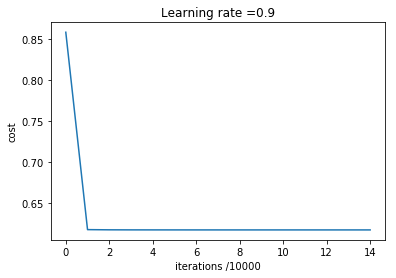

In [3]:
# lets train using the model we created in previous lecture and see the performance
layers = [1,15,1]
params = nn.llayermodel(x_tr, y_tr, layers, learning_rate=0.9, num_epochs=150000, print_cost=True, printerval=10000)
pY = nn.predict(x_te,params)

Predicted fit.....
The MSE is :  0.000184563770469


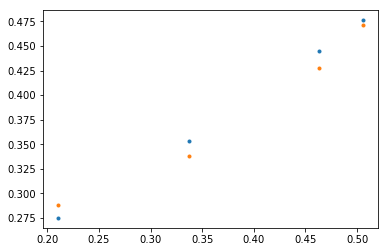

In [4]:
print("Predicted fit.....")
err = np.sum((pY - y_te)**2)/y_te.shape[1]
print("The MSE is : ", err)
plt.plot(x_te.T,pY.T,'.')
plt.plot(x_te.T,y_te.T,'.')
plt.show()

In [5]:
# defining new cost function
def compcost_reg(AL, Y, ld, parameters, reg):
    m = Y.shape[1]  # training batch size
    # cross entropy cost

    cost = (-1 / m) * (np.dot(Y, np.log(AL).T) + np.dot(1 - Y, np.log(1 - AL).T))

    cost = np.squeeze(cost)

    L = len(parameters) // 2 # number of layers in the neural network
    if (reg=='l2reg'):
        for l in range(L):
            cost = cost + ld*np.sum(np.sum(parameters["W" + str(l + 1)]**2))/2/m
    
    
    return cost

In [6]:
# defining new update rules:
def updateparams_reg(parameters, grads, learning_rate, ldbym, reg):
    
    
    
    L = len(parameters) // 2  # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        if (reg=='l2reg'):
            parameters["W" + str(l + 1)] = (1-ldbym)*parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        else:
            parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
            
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)] 

    return parameters

In [7]:
# defining new model with regularization parameter:........
def llayermodel(X, Y, layers, learning_rate=0.0007, ld = 0.001, reg = 'l2reg', num_epochs=10000, print_cost=True, printerval=1000):
    np.random.seed(1)
    costs = []  # keep track of cost
    
    [n, m] = X.shape
    # Parameters initialization.
    parameters = nn.initparams(layers)

    # Loop (gradient descent)
    if (reg == 'l2reg'):
        for i in range(0, num_epochs):
            # Forward propagation
            a3, caches = nn.lmodelfwd(X, parameters)

            # Compute cost
            cost = compcost_reg(a3, Y, ld, parameters, reg)

            # Backward propagation
            grads = nn.lmodelback(a3, Y, caches)

            # Update parameters
            parameters = updateparams_reg(parameters, grads, learning_rate, ld/m, reg)

            # Print the cost every 100 training example
            if print_cost and i % printerval == 0:
                print("Cost after iteration %i: %f" % (i, cost))
            if i % printerval == 0:
                costs.append(cost)
    else:
        for i in range(0, num_epochs):
            # Forward propagation
            a3, caches = nn.lmodelfwd(X, parameters)

            # Compute cost
            cost = nn.compcost(a3, Y)

            # Backward propagation
            grads = nn.lmodelback(a3, Y, caches)

            # Update parameters
            parameters = nn.updateparams(parameters, grads, learning_rate)

            # Print the cost every 100 training example
            if print_cost and i % printerval == 0:
                print("Cost after iteration %i: %f" % (i, cost))
            if i % printerval == 0:
                costs.append(cost)

    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations /' + str(printerval))
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters

Cost after iteration 0: 0.858579
Cost after iteration 10000: 0.617316
Cost after iteration 20000: 0.617122
Cost after iteration 30000: 0.617054
Cost after iteration 40000: 0.617012
Cost after iteration 50000: 0.616995
Cost after iteration 60000: 0.616984
Cost after iteration 70000: 0.616976
Cost after iteration 80000: 0.616970
Cost after iteration 90000: 0.616966
Cost after iteration 100000: 0.616962
Cost after iteration 110000: 0.616959
Cost after iteration 120000: 0.616957
Cost after iteration 130000: 0.616955
Cost after iteration 140000: 0.616954


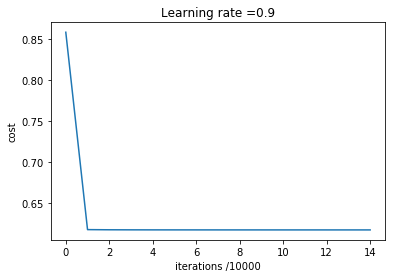

In [8]:
# lets train now with our new model.............
layers = [1,15,1]
params = llayermodel(x_tr, y_tr, layers, learning_rate=0.9, ld = 0.0002, reg='l2reg', num_epochs=150000, print_cost=True, printerval=10000)
pY = nn.predict(x_te,params)

Predicted fit.....
The MSE is :  0.000127912826732


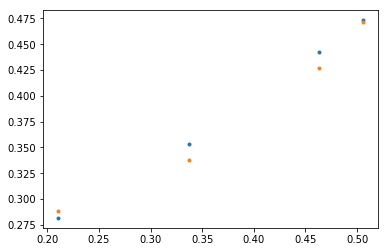

In [9]:
print("Predicted fit.....")
err = np.sum((pY - y_te)**2)/y_te.shape[1]
print("The MSE is : ", err)
plt.plot(x_te.T,pY.T,'.')
plt.plot(x_te.T,y_te.T,'.')
plt.show()

> you will see that the MSE of regularized model is less than the non-regularized since the overtraining complex model like this have increased the overfitting and hence the generalization gap.

### 2. Norm Penalties as Constrained Optimization
we can use norm penalties as a contrain condition over the solution we want to get see how:

> Read section 7.2 on reference book

### 3. Regularization and Under-Constrained Problems
In some cases, regularization is necessary for machine learning problems to be properly deﬁned.

> Read section 7.3 on reference book.

### 4. Dataset Augmentation

To generalize more better we augment the data we have to get more robust model see how:

> Read section 7.4 on reference book.

### 5. Noise Robustness

Noise can be introduced in hidden units, parameters or in output units of the network to make it robust see a brief about these:

> Read Section 7.5 on reference book.

### 6. Semi Supervised Learning

In the paradigm of semi-supervised learning, both unlabeled examples from P(x) and labeled examples from P(x, y) are used to estimate P(y | x) or predict y from x. The goal is to learn a representation so that examples from the same class have similar representations. Examples that cluster tightly in the input space should be mapped to similar representations.

> Read section 7.6

### 7. Multitask Learning

> Read Section 7.7

### 8. Early Stopping

Early stopping means storing the or stopping the training when we reach minimum validation set error to prevent overfitting and return the parameters wuth minimum generalization gap.

>Read Section 7.8

Let's implement this in our model......

In [10]:
# defining data
str_size = 12
x_str = x_tr[0,:str_size].reshape(1,str_size)
y_str = y_tr[0,:str_size].reshape(1,str_size)
x_val = x_tr[0,str_size:].reshape(1,tr_size-str_size)
y_val = y_tr[0,str_size:].reshape(1,tr_size-str_size)

In [11]:
# defining new model with regularization parameter:........
def llayermodel(X, Y, xval, yval, layers, learning_rate = 0.0007, ld = 0.001, 
                reg = 'none', estop = True, max_passes = 100, num_epochs=10000, print_cost=True, printerval=1000):
    np.random.seed(1)
    costs = []  # keep track of cost
    
    [n, m] = X.shape
    # Parameters initialization.
    parameters = nn.initparams(layers)

    valcst = 10**5
    passes = 0
    oparams = parameters
    
    # Loop (gradient descent)
    if (reg == 'l2reg'):
        for i in range(0, num_epochs):
            # Forward propagation
            a3, caches = nn.lmodelfwd(X, parameters)

            # Compute cost
            cost = compcost_reg(a3, Y, ld, parameters, reg)

            # Backward propagation
            grads = nn.lmodelback(a3, Y, caches)

            # Update parameters
            parameters = updateparams_reg(parameters, grads, learning_rate, ld/m, reg)

            # Print the cost every 100 training example
            if print_cost and i % printerval == 0:
                print("Cost after iteration %i: %f" % (i, cost))
            if i % printerval == 0:
                costs.append(cost)
                
            if(estop and i%10 == 0):    
                yvald = nn.predict(xval,parameters)
                vcost = compcost_reg(yvald, yval, ld, parameters, reg)
                if(vcost < valcst):
                    passes = 0
                    valcst = vcost
                    oparams = parameters
                else:
                    if(passes > max_passes):
                        parameters = oparams
                        print("breaking the loop........")
                        break
                    else:
                        passes = passes + 1
                    
                    
                
            
    else:
        for i in range(0, num_epochs):
            # Forward propagation
            a3, caches = nn.lmodelfwd(X, parameters)

            # Compute cost
            cost = nn.compcost(a3, Y)

            # Backward propagation
            grads = nn.lmodelback(a3, Y, caches)

            # Update parameters
            parameters = nn.updateparams(parameters, grads, learning_rate)

            # Print the cost every 100 training example
            if print_cost and i % printerval == 0:
                print("Cost after iteration %i: %f" % (i, cost))
            if i % printerval == 0:
                costs.append(cost)
                
            if(estop and i%10 == 0):    
                yvald = nn.predict(xval,parameters)
                vcost = nn.compcost(yvald, yval)
                if(vcost < valcst):
                    passes = 0
                    valcst = vcost
                    oparams = parameters
                else:
                    if(passes > max_passes):
                        parameters = oparams
                        print("breaking the loop........")
                        break
                    else:
                        passes = passes + 1

    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations /' + str(printerval))
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters

Cost after iteration 0: 0.774011
Cost after iteration 10000: 0.620052
Cost after iteration 20000: 0.620016
Cost after iteration 30000: 0.620005
Cost after iteration 40000: 0.619999
breaking the loop........


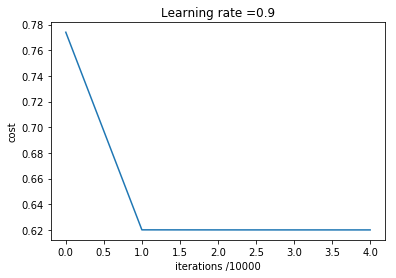

In [12]:
layers = [1,15,1]
params = llayermodel(x_str, y_str, x_val, y_val, layers, learning_rate = 0.9, ld = 0.001, reg = 'none', estop = True, max_passes = 100, num_epochs=150000, print_cost=True, printerval=10000)

Predicted fit.....
The MSE is :  4.18941037299e-05


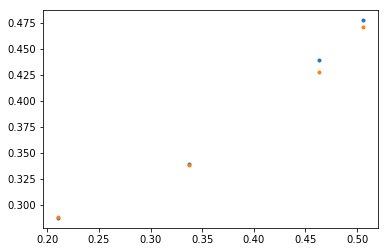

In [13]:
pY = nn.predict(x_te,params)
print("Predicted fit.....")
err = np.sum((pY - y_te)**2)/y_te.shape[1]
print("The MSE is : ", err)
plt.plot(x_te.T,pY.T,'.')
plt.plot(x_te.T,y_te.T,'.')
plt.show()

> We got the better result with out iterating for 150000 iterations which is quiet remarkable if you think it saves the computaion time.


---------------

### 9. Parameter Tying and Parameter Sharing

This part will be related to convolutional nueral network understsanding:.... see how and why how parameter sharing reduces the memory footprint of the model required to train multiple classifiers.

> Read section 7.9

### 10. Sparse Representations
There are many ways to regularize a model to make it sparse. one way we discussed already was L1 regularization in which the weights were constrained to become zero in some places. Similarily we can make outputs of hidden nodes to be contrained to become zero.

> Read section 7.10

Let's see what weights do we get with L1 regularization.

In [14]:
# defining new cost function
def compcost_reg(AL, Y, ld, parameters, reg):
    m = Y.shape[1]  # training batch size
    # cross entropy cost

    cost = (-1 / m) * (np.dot(Y, np.log(AL).T) + np.dot(1 - Y, np.log(1 - AL).T))

    cost = np.squeeze(cost)

    L = len(parameters) // 2 # number of layers in the neural network
    if (reg == 'l2reg'):
        for l in range(L):
            cost = cost + ld*np.sum(np.sum(parameters["W" + str(l + 1)]**2))/2/m
    
    elif(reg == 'l1reg'):
        alpha = 10**-20
        for l in range(L):
            cost = cost + ld*np.sum(np.sum(np.sqrt(parameters["W" + str(l + 1)]**2 + alpha)))/m    
    else:
        pass
    
    return cost

In [15]:
# defining new update rules:
def updateparams_reg(parameters, grads, learning_rate, ldbym, reg):
    
    
    
    L = len(parameters) // 2  # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        if (reg == 'l2reg'):
            parameters["W" + str(l + 1)] = (1-ldbym)*parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        elif(reg == 'l1reg'):
            parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)] - ldbym*np.sign(parameters["W" + str(l + 1)])
        else:
            parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
            
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)] 

    return parameters

In [16]:
# defining new model with regularization parameter:........
def llayermodel_2(X, Y, xval, yval, layers, learning_rate = 0.0007, ld = 0.001, 
                reg = 'none', estop = True, max_passes = 100, num_epochs=10000, print_cost=True, printerval=1000, plotcost = True):
    np.random.seed(1)
    costs = []  # keep track of cost
    
    [n, m] = X.shape
    # Parameters initialization.
    parameters = nn.initparams(layers)

    valcst = 10**5
    passes = 0
    oparams = parameters
    
    # Loop (gradient descent)
    if (reg == 'l2reg' or reg == 'l1reg'):
        for i in range(0, num_epochs):
            # Forward propagation
            a3, caches = nn.lmodelfwd(X, parameters)

            # Compute cost
            if(plotcost):
                cost = compcost_reg(a3, Y, ld, parameters, reg)

            # Backward propagation
            grads = nn.lmodelback(a3, Y, caches)

            # Update parameters
            parameters = updateparams_reg(parameters, grads, learning_rate, ld/m, reg)

            # Print the cost every 100 training example
            if(plotcost):
                if print_cost and i % printerval == 0:
                    print("Cost after iteration %i: %f" % (i, cost))
                if i % printerval == 0:
                    costs.append(cost)
                
            if(estop and i%10 == 0):    
                yvald = nn.predict(xval,parameters)
                vcost = compcost_reg(yvald, yval, ld, parameters, reg)
                if(vcost < valcst):
                    passes = 0
                    valcst = vcost
                    oparams = parameters
                else:
                    if(passes > max_passes):
                        parameters = oparams
                        print("breaking the loop........")
                        break
                    else:
                        passes = passes + 1
                    
                    
                
            
    else:
        for i in range(0, num_epochs):
            # Forward propagation
            a3, caches = nn.lmodelfwd(X, parameters)

            # Compute cost
            if(plotcost):
                cost = nn.compcost(a3, Y)

            # Backward propagation
            grads = nn.lmodelback(a3, Y, caches)

            # Update parameters
            parameters = nn.updateparams(parameters, grads, learning_rate)

            # Print the cost every 100 training example
            if(plotcost):
                if print_cost and i % printerval == 0:
                    print("Cost after iteration %i: %f" % (i, cost))
                if i % printerval == 0:
                    costs.append(cost)
                
            if(estop and i%10 == 0):    
                yvald = nn.predict(xval,parameters)
                vcost = nn.compcost(yvald, yval)
                if(vcost < valcst):
                    passes = 0
                    valcst = vcost
                    oparams = parameters
                else:
                    if(passes > max_passes):
                        parameters = oparams
                        print("breaking the loop........")
                        break
                    else:
                        passes = passes + 1

    # plot the cost
    if(plotcost):
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations /' + str(printerval))
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

    return parameters

Cost after iteration 0: 0.775852
Cost after iteration 10000: 0.621231
Cost after iteration 20000: 0.620691
Cost after iteration 30000: 0.620577
Cost after iteration 40000: 0.620515
Cost after iteration 50000: 0.620515
Cost after iteration 60000: 0.620515
Cost after iteration 70000: 0.620515
Cost after iteration 80000: 0.620515
Cost after iteration 90000: 0.620515
Cost after iteration 100000: 0.620515
Cost after iteration 110000: 0.620515
Cost after iteration 120000: 0.620515
Cost after iteration 130000: 0.620515
Cost after iteration 140000: 0.620515


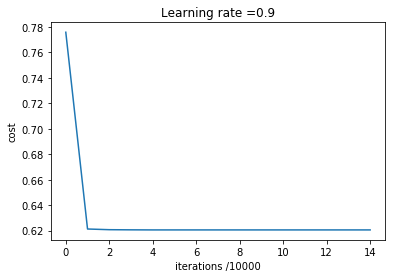

In [17]:
layers = [1,15,1]
params = llayermodel_2(x_str, y_str, x_val, y_val, layers, learning_rate = 0.9, ld = 0.001, reg = 'l1reg', estop = False, max_passes = 100, num_epochs=150000, print_cost=True, printerval=10000, plotcost = True)

Predicted fit.....
The MSE is :  0.000416560796921


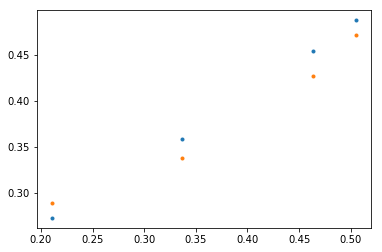

In [18]:
pY = nn.predict(x_te,params)
print("Predicted fit.....")
err = np.sum((pY - y_te)**2)/y_te.shape[1]
print("The MSE is : ", err)
plt.plot(x_te.T,pY.T,'.')
plt.plot(x_te.T,y_te.T,'.')
plt.show()

In [19]:
print(params)
print("\nAs you can see many of the weight parameters are nearly zero..." )

{'W1': array([[  7.18867550e-06],
       [  6.93605424e-05],
       [ -3.94411545e-06],
       [ -5.38968351e-05],
       [ -5.87009154e-05],
       [ -3.95172922e-05],
       [  2.58032415e-05],
       [  2.04555210e-05],
       [ -7.60835258e-05],
       [ -1.14558308e-05],
       [  6.70164686e-05],
       [  1.77758330e+00],
       [ -5.31509193e-05],
       [ -8.14809014e-05],
       [ -3.48009965e-05]]), 'b1': array([[ -3.34155148e-03],
       [ -1.44214718e-01],
       [ -4.67622000e-02],
       [ -1.05620513e-03],
       [  5.29829550e-01],
       [  8.54430819e-01],
       [  6.50304023e-02],
       [ -1.50536747e-03],
       [ -2.65280958e-04],
       [  5.99218371e-01],
       [ -9.36702685e-05],
       [ -3.29016129e-01],
       [ -3.96156230e-02],
       [ -1.42334971e-02],
       [ -2.23828823e-02]]), 'W2': array([[  5.14427454e-05,   8.13853859e-05,   7.73367715e-05,
          6.50804570e-05,   3.44982973e-05,   4.45351757e-05,
         -1.56112075e-05,   1.32748301e-06,

### 11. Bagging and Other Ensemble Methods
Every model involves some error for a given data samples but it's not necessary that they make related errors and so one can compensate for another so averaging over these models can be done which is called bagging in which we make k models with k datasets which are obtained from original dataset alterations.

> Read section 7.11

In [22]:
# defining bags
def make_bags(x,y,k):
    m = y.shape[1]
    np.random.seed(12)
    bags = {}
    for i in range(k):
        permutation = np.random.randint(0,m-1,m) + (np.random.randn(1,m)>0)
        bags['bag_x' + str(i)] = x[:,permutation]
        bags['bag_y' + str(i)] = y[:,permutation]
        
    return bags

def train_bagging(x_str, y_str, x_val, y_val, layers, k = 5, learning_rate = 0.9, ld = 0.001, reg = 'l1reg', estop = False, max_passes = 100, num_epochs=15000, print_cost=False, printerval=1000):
    
    bags = make_bags(x_str,y_str,k)
    params = {}
    for i in range(k):
        print('Training bag no.' + str(i))
        x_trn = bags['bag_x'+str(i)].reshape(x_str.shape[0],x_str.shape[1])
        y_trn = bags['bag_y'+str(i)].reshape(y_str.shape[0],y_str.shape[1])
        params['p'+ str(i)] = llayermodel_2(x_trn, y_trn, x_val, y_val, layers, learning_rate = learning_rate, ld = ld, 
                                          reg = reg, estop = estop, max_passes = max_passes, num_epochs=num_epochs, print_cost=print_cost, printerval=printerval, plotcost=False)
    
    return params

def predict_bagging(x,params):
    k = len(params)
    pY = nn.predict(x,params['p0'])
    for i in range(1,k):
        pY = pY + nn.predict(x,params['p' + str(i)])
        
    pY = pY/k
    
    return pY

In [23]:
paramsbagging = train_bagging(x_str, y_str, x_val, y_val, layers, k = 10, learning_rate = 0.9, ld = 0.001, reg = 'none', estop = True, max_passes = 50, num_epochs=150000, print_cost=False, printerval=10000)

Training bag no.0
Training bag no.1
breaking the loop........
Training bag no.2
breaking the loop........
Training bag no.3
breaking the loop........
Training bag no.4
breaking the loop........
Training bag no.5
breaking the loop........
Training bag no.6
breaking the loop........
Training bag no.7
Training bag no.8
breaking the loop........
Training bag no.9
breaking the loop........


Predicted fit.....
The MSE is :  0.000175774425373


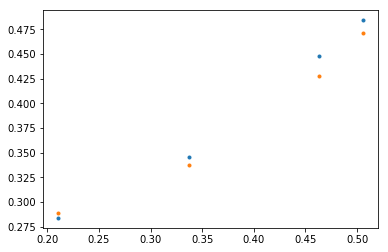

In [24]:
pY = predict_bagging(x_te,paramsbagging)
print("Predicted fit.....")
err = np.sum((pY - y_te)**2)/y_te.shape[1]
print("The MSE is : ", err)
plt.plot(x_te.T,pY.T,'.')
plt.plot(x_te.T,y_te.T,'.')
plt.show()

### 12. Dropout

Similar to bagging which create different models dropout trains the same model over different minibatches and simultaneously eliminating random nodes on each level to create different network structure each time which indirectly removes the contribution of uncessary nodes using random masks on the layer. So far, dropout remains the most widely used implicit ensemble method.

> Read Section 7.12

In [25]:
# for implementation of dropout we need to modify the layer calculation rules:
def lmodelfwd_reg(X, parameters, streg = 'none',stld = 0.5):

    """
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()

    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2  # number of layers in the neural network L = len(w's) + len(b's) = 2xdepth
    masks = {}
    for l in range(1, L):
        A_prev = A
        if (streg == 'dout'):
            A, cache = nn.linactfwd(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], "relu")
            mask = np.random.binomial(1,stld,size=A.shape) / stld
            masks['m'+str(l)] = mask
        else:
            A, cache = nn.linactfwd(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], "relu")
        
        caches.append(cache)

    AL, cache = nn.linactfwd(A, parameters['W' + str(L)], parameters['b' + str(L)], "sigmoid")

    caches.append(cache)

    return AL, caches, masks

In [26]:
def lmodelback_reg(AL, Y, caches, masks, streg= 'none'):
    """
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])

    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ...
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ...
    """

    grads = {}
    L = len(caches)  # the number of layers
    m = AL.shape[1]
    n = AL.shape[0]
    Y = Y.reshape(AL.shape)  
	# after this line, Y is the same shape as AL
    # Initializing the backpropagation
	# Zero divide avoided
    en = 10**-20 # a very small number

    try:
        dAL = (-np.divide(Y, AL) + np.divide(1 - Y, 1 - AL))/m
    except ZeroDivisionError:
        dAL = (-np.divide(Y, AL+np.sign(AL)*en) + np.divide(1 - Y, 1 - AL + np.sign(1-AL)*en))/m

    #dAL = -(1/m)*(Y-AL)


    current_cache = caches[L - 1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = nn.linactback(dAL, current_cache, "sigmoid")
    grads["dA" + str(L)] = grads["dA" + str(L)]*masks['m' + str(L-1)]
    for l in reversed(range(L - 1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        if (streg=='dout' and l > 1):
            dA_prev_temp, dW_temp, db_temp = nn.linactback(grads["dA" + str(l + 2)], current_cache, "relu")
            dA_prev_temp = dA_prev_temp*masks['m'+str(l)]
        else:
            dA_prev_temp, dW_temp, db_temp = nn.linactback(grads["dA" + str(l + 2)], current_cache, "relu")

        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [ ]:
# defining new model with regularization parameter:........
def llayermodel_3(X, Y, xval, yval, layers, learning_rate = 0.0007, streg = 'none', stld = 0.5, ld = 0.001, 
                reg = 'none', estop = True, max_passes = 100, num_epochs=10000, print_cost=True, printerval=1000, plotcost = True):
    np.random.seed(1)
    costs = []  # keep track of cost
    
    [n, m] = X.shape
    # Parameters initialization.
    parameters = nn.initparams(layers)

    valcst = 10**5
    passes = 0
    oparams = parameters
    
    # Loop (gradient descent)
    if(streg=='dout'):
        if (reg == 'l2reg' or reg == 'l1reg'):
            for i in range(0, num_epochs):
                # Forward propagation
                a3, caches, masks = lmodelfwd_reg(X, parameters, streg, stld)

                # Compute cost
                if(plotcost):
                    cost = compcost_reg(a3, Y, ld, parameters, reg)

                # Backward propagation
                grads = lmodelback_reg(a3, Y, caches, masks, streg)

                # Update parameters
                parameters = updateparams_reg(parameters, grads, learning_rate, ld/m, reg)

                # Print the cost every 100 training example
                if(plotcost):
                    if print_cost and i % printerval == 0:
                        print("Cost after iteration %i: %f" % (i, cost))
                    if i % printerval == 0:
                        costs.append(cost)

                if(estop and i%10 == 0):    
                    yvald = nn.predict(xval,parameters)
                    vcost = compcost_reg(yvald, yval, ld, parameters, reg)
                    if(vcost < valcst):
                        passes = 0
                        valcst = vcost
                        oparams = parameters
                    else:
                        if(passes > max_passes):
                            parameters = oparams
                            print("breaking the loop........")
                            break
                        else:
                            passes = passes + 1




        else:
            for i in range(0, num_epochs):
                # Forward propagation
                a3, caches, masks = lmodelfwd_reg(X, parameters, streg, stld)

                # Compute cost
                if(plotcost):
                    cost = nn.compcost(a3, Y)

                # Backward propagation
                grads = lmodelback_reg(a3, Y, caches, masks, streg)

                # Update parameters
                parameters = nn.updateparams(parameters, grads, learning_rate)

                # Print the cost every 100 training example
                if(plotcost):
                    if print_cost and i % printerval == 0:
                        print("Cost after iteration %i: %f" % (i, cost))
                    if i % printerval == 0:
                        costs.append(cost)

                if(estop and i%10 == 0):    
                    yvald = nn.predict(xval,parameters)
                    vcost = nn.compcost(yvald, yval)
                    if(vcost < valcst):
                        passes = 0
                        valcst = vcost
                        oparams = parameters
                    else:
                        if(passes > max_passes):
                            parameters = oparams
                            print("breaking the loop........")
                            break
                        else:
                            passes = passes + 1
    else:
        if (reg == 'l2reg' or reg == 'l1reg'):
            for i in range(0, num_epochs):
                # Forward propagation
                a3, caches = nn.lmodelfwd(X, parameters)

                # Compute cost
                if(plotcost):
                    cost = compcost_reg(a3, Y, ld, parameters, reg)

                # Backward propagation
                grads = nn.lmodelback(a3, Y, caches)

                # Update parameters
                parameters = updateparams_reg(parameters, grads, learning_rate, ld/m, reg)

                # Print the cost every 100 training example
                if(plotcost):
                    if print_cost and i % printerval == 0:
                        print("Cost after iteration %i: %f" % (i, cost))
                    if i % printerval == 0:
                        costs.append(cost)

                if(estop and i%10 == 0):    
                    yvald = nn.predict(xval,parameters)
                    vcost = compcost_reg(yvald, yval, ld, parameters, reg)
                    if(vcost < valcst):
                        passes = 0
                        valcst = vcost
                        oparams = parameters
                    else:
                        if(passes > max_passes):
                            parameters = oparams
                            print("breaking the loop........")
                            break
                        else:
                            passes = passes + 1




        else:
            for i in range(0, num_epochs):
                # Forward propagation
                a3, caches = nn.lmodelfwd(X, parameters)

                # Compute cost
                if(plotcost):
                    cost = nn.compcost(a3, Y)

                # Backward propagation
                grads = nn.lmodelback(a3, Y, caches)

                # Update parameters
                parameters = nn.updateparams(parameters, grads, learning_rate)

                # Print the cost every 100 training example
                if(plotcost):
                    if print_cost and i % printerval == 0:
                        print("Cost after iteration %i: %f" % (i, cost))
                    if i % printerval == 0:
                        costs.append(cost)

                if(estop and i%10 == 0):    
                    yvald = nn.predict(xval,parameters)
                    vcost = nn.compcost(yvald, yval)
                    if(vcost < valcst):
                        passes = 0
                        valcst = vcost
                        oparams = parameters
                    else:
                        if(passes > max_passes):
                            parameters = oparams
                            print("breaking the loop........")
                            break
                        else:
                            passes = passes + 1

    # plot the cost
    if(plotcost):
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations /' + str(printerval))
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

    return parameters

In [ ]:
layers = [1,15,1]
params = llayermodel_3(x_str, y_str, x_val, y_val, layers, learning_rate = 0.9, streg = 'dout', stld = 0.5, ld = 0.001,
                reg = 'none', estop = True, max_passes = 1000, num_epochs=150000, print_cost=True, printerval=10000, plotcost = True)

In [ ]:
pY = nn.predict(x_te,params)
print("Predicted fit.....")
err = np.sum((pY - y_te)**2)/y_te.shape[1]
print("The MSE is : ", err)
plt.plot(x_te.T,pY.T,'.')
plt.plot(x_te.T,y_te.T,'.')
plt.show()

>NOTE: why did dropout give so good result in less number of iterations because in a way drop out forces the nodes to contain independent features and not interelated data so that if a node goes off the data on other nodes not to be affected and so nodes contains may be repeated bbut independent features.

### 13. Adversarial Training

> Read section 7.11


### 14. Tangent Distance, Tangent Prop and ManifoldTangent Classiﬁer

Say you have a image of letter A and a image where A is laterally tilted these two falls on same manifold but will out model predict them in same class(A) see a method which can help us with it.

> Read section 7.13 <br> Also read this article :http://papers.nips.cc/paper/4409-the-manifold-tangent-classifier.pdf 